In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/UGM'
WORKING_DIR = '/content/drive/MyDrive/Working'

In [ ]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'imgs')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/2100 [00:00<?, ?it/s]

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'featuresVGG16.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
import json
with open(os.path.join(BASE_DIR, 'dataset.json'), 'r') as f:
    #next(f)
    captions_doc = json.load(f)
    #captions_doc = f.read()

In [ ]:
captions_str = str(captions_doc)
captions_list = captions_str.split('\n')

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for i in range(2100):
  for j in range(5):
    image_id = captions_doc['images'][i]['filename']
    caption = captions_doc['images'][i]['sentences'][j]['raw']
    image_id = image_id.split('.')[0]
    if image_id not in mapping:
      mapping[image_id] = []
    mapping[image_id].append(caption)

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption

            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
mapping['1']

['There is a piece of farmland .',
 'There is a piece of cropland .',
 'It is a piece of farmland .',
 'It is a piece of cropland .',
 'Here is a piece of farmland .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1']

['startseq there is piece of farmland endseq',
 'startseq there is piece of cropland endseq',
 'startseq it is piece of farmland endseq',
 'startseq it is piece of cropland endseq',
 'startseq here is piece of farmland endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

23

In [ ]:
trainim = list()
testim = list()
for i in range(2100):
  trainortest = captions_doc['images'][i]['split']
  if(trainortest == "test"):
    testim.append(i+1)
  else:
    trainim.append(i+1)

In [ ]:
trainim = list(map(str, trainim))

In [ ]:
testim = list(map(str, testim))

In [ ]:
from sklearn.model_selection import train_test_split
train2, val2 = train_test_split(trainim, test_size=2/9, random_state=42)

In [ ]:
len(train2)

1470

In [ ]:
len(val2)

420

In [ ]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

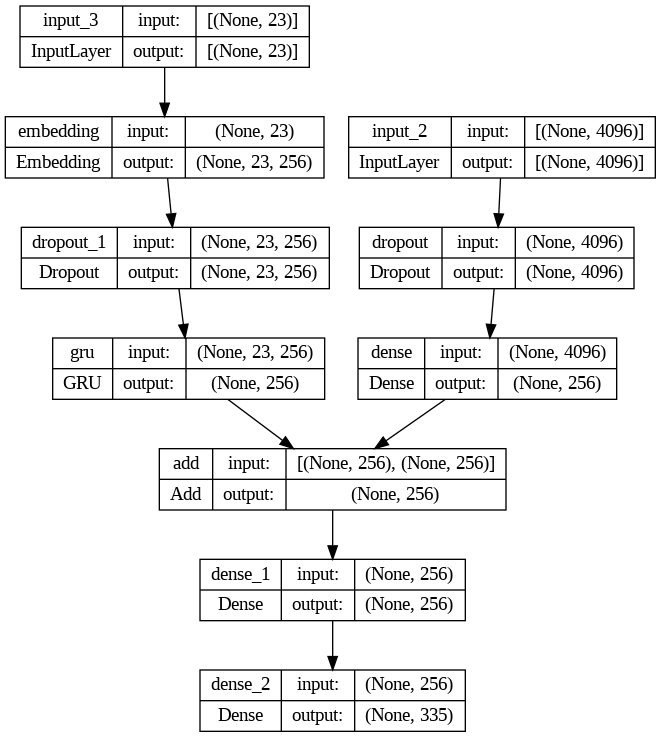

In [ ]:
from keras.layers import GRU
from tensorflow.keras.optimizers import Adam

# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = GRU(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

optimizer = Adam(learning_rate=0.0001)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
    epochs = 64
    batch_size = 128
    steps = len(train2) // batch_size
    #steps = 12

    for i in range(epochs):
        # create data generator
        generator = data_generator(train2, mapping, features, tokenizer, max_length, vocab_size, batch_size)
        #generator2 = data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)
        generator3 = data_generator(val2, mapping, features, tokenizer, max_length, vocab_size, batch_size)

        # fit for one epoch
        model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, validation_steps=steps, validation_data=generator3)

11/11 [==============================] - 6s 632ms/step - loss: 0.2259 - val_loss: 0.6765


In [ ]:
# save the model
#model.save(WORKING_DIR+'/GRUe64b128.h5')
model = keras.models.load_model(WORKING_DIR+'/GRUe64b128.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = [], []

for key in tqdm(testim):#test
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

  0%|          | 0/210 [00:00<?, ?it/s]

In [ ]:
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.808041
BLEU-2: 0.726508
BLEU-3: 0.670042
BLEU-4: 0.615177


In [ ]:
import nltk
nltk.download('wordnet')

In [ ]:
from nltk.translate.meteor_score import single_meteor_score

toplam=0
for i in range(0, len(actual)):
  score1 = single_meteor_score(actual[i][2][1:-1],predicted[i][1:-1])
  toplam = score1 + toplam

toplam

In [ ]:
toplam/len(actual)

In [ ]:
toplam/len(actual)

0.5341705735574432

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "imgs", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq this is beach with blue sea and white sands endseq
startseq waves are slapping white sand beach while some birds flying endseq
startseq waves are slapping white sand beach over and over again and throw up white foam endseq
startseq waves beat on the beach over and over again endseq
startseq waves are slapping the white sand beach and throwing up white foams endseq
--------------------Predicted--------------------
startseq waves slapping white sand beach throw up white foam endseq


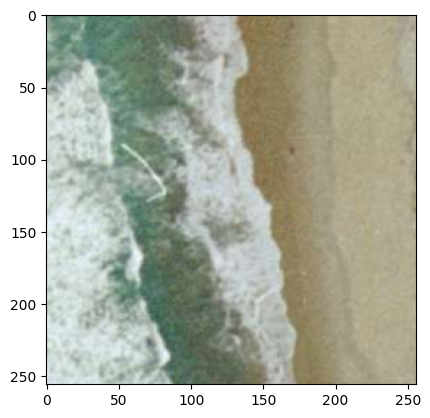

In [ ]:
generate_caption("397.tif")